In [ ]:
# This kernel have improvement from Pranav Pandya and Andy Harless
# Pranav Kernel: https://www.kaggle.com/pranav84/xgboost-on-hist-mode-ip-addresses-dropped
# Andy Kernel: https://www.kaggle.com/aharless/jo-o-s-xgboost-with-memory-usage-enhancements

In [4]:
import gc
import time
import numpy as np
import pandas as pd
#from sklearn.cross_validation import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

In [2]:
# Change this for validation with 10% from train
is_valid = False
path = './data/'

# Load Data

In [5]:
start_time = time.time()

train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

# Read the last lines because they are more impacting in training than the starting lines
#train = pd.read_csv(path+"train.csv", skiprows=range(1,123903891), nrows=61000000, usecols=train_columns, dtype=dtypes)
train = pd.read_csv(path+"train.csv", usecols=train_columns, dtype=dtypes)
test = pd.read_csv(path+"test.csv", usecols=test_columns, dtype=dtypes)

print('[{}] Finished to load data'.format(time.time() - start_time))

[325.07735991477966] Finished to load data


In [6]:
# Drop the IP and the columns from target
y = train['is_attributed']
train.drop(['is_attributed'], axis=1, inplace=True)

nrow_train = train.shape[0]

total_df = train.append(test,sort=False)
total_df.head()

del train, test
gc.collect()


28

# Add Feature

## Time Feature

In [7]:
total_df['hour'] = pd.to_datetime(total_df.click_time).dt.hour.astype('uint8')
#total_df['day'] = pd.to_datetime(total_df.click_time).dt.day.astype('uint8')

gc.collect()

17

## Group Feature

In [8]:
# Count the number of clicks by ip
ip_count = total_df.groupby(['ip'])['channel'].count().reset_index()
ip_count.columns = ['ip', 'clicks_by_ip']
total_df = pd.merge(total_df, ip_count, on='ip', how='left', sort=False)
total_df['clicks_by_ip'] = total_df['clicks_by_ip'].astype('uint16')
total_df.head()

,ip,app,device,os,channel,click_time,click_id,hour,clicks_by_ip
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,14,28085
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,14,26234
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,14,11002
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,14,57669
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,14,1171


In [9]:
# group ip-app
gp = total_df[['ip', 'app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
total_df = total_df.merge(gp, on=['ip','app'], how='left')
total_df['ip_app_count'] = total_df['ip_app_count'].astype('uint16')
del gp
gc.collect()

63

# Train Model

## Data Split

In [10]:
total_df.drop(['click_time'], axis=1,inplace=True)
train = total_df[:nrow_train]
test = total_df[nrow_train:]
test.head()

,ip,app,device,os,channel,click_id,hour,clicks_by_ip,ip_app_count
184903890,5744,9,1,3,107,0.0,4,1134,113
184903891,119901,9,1,3,466,1.0,4,23273,2302
184903892,72287,21,1,19,128,2.0,4,15544,701
184903893,78477,15,1,13,111,3.0,4,12827,827
184903894,123080,12,1,13,328,4.0,4,1441,205


In [11]:
predictors = ['app','device','os', 'channel', 'hour', 
              'clicks_by_ip','ip_app_count']

In [12]:
del total_df
gc.collect()

7

## Set Parameters

In [13]:
# Set the params(this params from Pranav kernel) for xgboost model
params = {'eta': 0.3,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'max_depth': 0, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0,
          'alpha':4,
          'objective': 'binary:logistic', 
          'scale_pos_weight':9,
          'eval_metric': 'auc', 
          'nthread':8,
          'random_state': 99, 
          'silent': True}

## Train

In [14]:
if (is_valid == True):
    # Get 10% of train dataset to use as validation
    x1, x2, y1, y2 = train_test_split(train[predictors], y, test_size=0.1, random_state=99)
    dtrain = xgb.DMatrix(x1, y1)
    dvalid = xgb.DMatrix(x2, y2)
    del x1, y1, x2, y2 
    gc.collect()
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    model = xgb.train(params, dtrain, 200, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=5)
    del dvalid
else:
    dtrain = xgb.DMatrix(train[predictors], y)
    del train, y
    gc.collect()
    watchlist = [(dtrain, 'train')]
    model = xgb.train(params, dtrain, 30, watchlist, maximize=True, verbose_eval=1)

del dtrain
gc.collect()

print('[{}] Finish XGBoost Training'.format(time.time() - start_time))

/home/jinpwa/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/jinpwa/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-auc:0.964395
[1]	train-auc:0.965101
[2]	train-auc:0.966512
[3]	train-auc:0.967466
[4]	train-auc:0.96855
[5]	train-auc:0.968784
[6]	train-auc:0.967645
[7]	train-auc:0.96903
[8]	train-auc:0.96949
[9]	train-auc:0.970118
[10]	train-auc:0.970133
[11]	train-auc:0.970752
[12]	train-auc:0.970542
[13]	train-auc:0.971231
[14]	train-auc:0.971807
[15]	train-auc:0.973176
[16]	train-auc:0.973769
[17]	train-auc:0.97382
[18]	train-auc:0.974021
[19]	train-auc:0.974623
[20]	train-auc:0.975306
[21]	train-auc:0.975559
[22]	train-auc:0.976179
[23]	train-auc:0.976604
[24]	train-auc:0.977164
[25]	train-auc:0.97759
[26]	train-auc:0.977901
[27]	train-auc:0.97817
[28]	train-auc:0.978596
[29]	train-auc:0.978968
[4991.9190492630005] Finish XGBoost Training


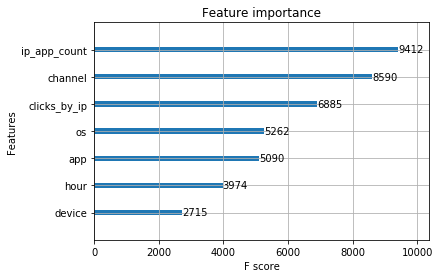

In [15]:
# Plot the feature importance from xgboost
plot_importance(model)
plt.gcf().savefig('feature_importance_xgb.png')

# Predict

In [16]:
sub = pd.DataFrame()
sub['click_id'] = test['click_id'].astype('int')

dtest = xgb.DMatrix(test[predictors])
#del test
gc.collect()

# Save the predictions
sub['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)
sub.to_csv('xgb_sub.csv', float_format='%.8f', index=False)

In [27]:
sub.shape

(18790469, 2)